<a href="https://colab.research.google.com/github/Jason-Shuler/NYC_Airbnb/blob/main/NYC_Airbnb_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



<h1 align="center">
    NYC Airbnb Market Analysis & Revenue Optimization
</h1>
<h3 align="center">
    Jason Shuler
</h3>


#### Import Libraries


In [6]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import pandas as pd
import numpy as np
import sqlite3

### Connect to the Database


In [8]:
# Connect to the SQLite database
conn = sqlite3.connect('airbnb.db')
cursor = conn.cursor()

#### Load the Dataset

In [9]:
data_path = 'AB_NYC_2019.csv'
df = pd.read_csv(data_path)
df.to_sql('listings', conn, if_exists='replace', index=False)

29203

- Found the top 10 hosts with the highest average ratings.

In [10]:
query = """
SELECT host_name, SUM(number_of_reviews) AS num_reviews, AVG(reviews_per_month) AS avg_rating
FROM listings
GROUP BY host_name
ORDER BY avg_rating DESC
LIMIT 10;
"""

In [11]:
result = pd.read_sql_query(query, conn)
print("\nAnalyzing Host Performance:")
print(result)


Analyzing Host Performance:
   host_name  num_reviews  avg_rating
0    Nalicia        744.0     18.7850
1       Dona       1205.0     13.9900
2     Malini        392.0     13.1500
3    Anabell        259.0     12.9900
4    Miss Dy        434.0     12.8400
5    Deloris        693.0     12.4800
6  Balwinder        272.0     11.5600
7       Asad        863.0     10.6525
8    James &        222.0     10.3900
9        Win        141.0     10.1900


- Show the month, average price, and number of listings for each month.

In [12]:
query = """
SELECT strftime('%m', last_review) AS month, AVG(price) AS avg_price,
COUNT(*) AS num_listings FROM listings
GROUP BY month
ORDER BY avg_price DESC;
"""

In [13]:
result = pd.read_sql_query(query, conn)
print("Analyzing Monthly Price Trends:")
print(result)

Analyzing Monthly Price Trends:
   month   avg_price  num_listings
0   None  180.776765          4830
1     12  164.708490          1331
2     01  155.705374          2084
3     02  154.075000           480
4     09  147.539659          1349
5     10  146.614420          1276
6     03  143.754624           811
7     04  143.144036          1333
8     11  140.844469           913
9     07  139.152737          3051
10    06  136.209265          7426
11    05  135.706088          2858
12    08  131.183436          1461


-  Found the top 5 neighborhoods with the highest price variability.
-  Displayed neighborhood and price variability.


In [14]:
query = """
WITH price_variability AS (
  SELECT neighbourhood, AVG(price) AS avg_price, MAX(price) AS max_price, MIN(price) AS min_price
  FROM listings
  GROUP BY neighbourhood
)
SELECT neighbourhood, max_price - min_price AS price_variability FROM price_variability
ORDER BY price_variability DESC
LIMIT 5;
"""

In [15]:
result = pd.read_sql_query(query, conn)
print("Advanced Aggregation:")
print(result)

Advanced Aggregation:
     neighbourhood  price_variability
0       Greenpoint            10000.0
1          Astoria             9973.0
2  Lower East Side             9970.0
3      East Harlem             9969.0
4     Clinton Hill             7965.0


- Calculated days since the last review
- Displayed listing ID, name, and days since the last review.

In [16]:
query = """
SELECT id, name, ROUND(julianday('now') - julianday(last_review), 0) AS days_since_last_review
FROM listings
ORDER BY days_since_last_review DESC
LIMIT 10;
"""

In [17]:
result = pd.read_sql_query(query, conn)
print("\nAdvanced Data Manipulation:")
print(result)


Advanced Data Manipulation:
       id                                               name  \
0   74860  Sunlit and Cozy Williamsburg/Greenpoint, Brooklyn   
1   40039                 Luxurious Condo in DUBMO with View   
2   81739                  Loft w/ Terrace @ Box House Hotel   
3   28396                  Modern Apt with Spectacular Views   
4   32363                 Fully Furnished Basement Apartment   
5   27883                             East Village Sanctuary   
6    7801                   Sweet and Spacious Brooklyn Loft   
7  229874                     Oversized Studio in Park Slope   
8   98330                LOVELY APARTMENT IN THE HEART OF NY   
9  464231                     Large Room w/ Private Entrance   

   days_since_last_review  
0                  5399.0  
1                  5371.0  
2                  5354.0  
3                  5225.0  
4                  5224.0  
5                  5142.0  
6                  5124.0  
7                  5119.0  
8             

- Calculated total revenue generated by each host and ranked them based on revenue.
- Showed the host name, total revenue, and their rank.

In [18]:
query = """
SELECT host_name, SUM(price * minimum_nights) AS total_revenue,
RANK() OVER (ORDER BY SUM(price * minimum_nights) DESC) AS revenue_rank
FROM listings
GROUP BY host_name
ORDER BY total_revenue DESC
LIMIT 10;
"""

In [19]:
result = pd.read_sql_query(query, conn)
print("Identifying Top Hosts by Revenue:")
print(result)

Identifying Top Hosts by Revenue:
        host_name  total_revenue  revenue_rank
0             Amy      1116679.0             1
1            Kara      1103594.0             2
2        Kathrine      1002082.0             3
3           Iveta       857750.0             4
4           Henry       591430.0             5
5             Ken       544605.0             6
6            Mark       483650.0             7
7           Peter       465571.0             8
8         Michael       457028.0             9
9  Jeremy & Laura       447810.0            10


In [20]:
query_segmentation = """
SELECT
    CASE
        WHEN price < 100 THEN 'Budget (<$100)'
        WHEN price BETWEEN 100 AND 300 THEN 'Standard ($100-$300)'
        ELSE 'Premium (>$300)'
    END AS price_category,
    COUNT(*) AS total_listings,
    ROUND(AVG(reviews_per_month), 2) AS avg_monthly_reviews,
    ROUND(AVG(availability_365), 0) AS avg_days_available
FROM listings
GROUP BY price_category
ORDER BY avg_days_available DESC;
"""

result_segmentation = pd.read_sql_query(query_segmentation, conn)
print("Market Segmentation Analysis:")
print(result_segmentation)

Market Segmentation Analysis:
         price_category  total_listings  avg_monthly_reviews  \
0       Premium (>$300)            1680                 0.80   
1  Standard ($100-$300)           14595                 0.97   
2        Budget (<$100)           12928                 1.10   

   avg_days_available  
0               141.0  
1               100.0  
2                93.0  


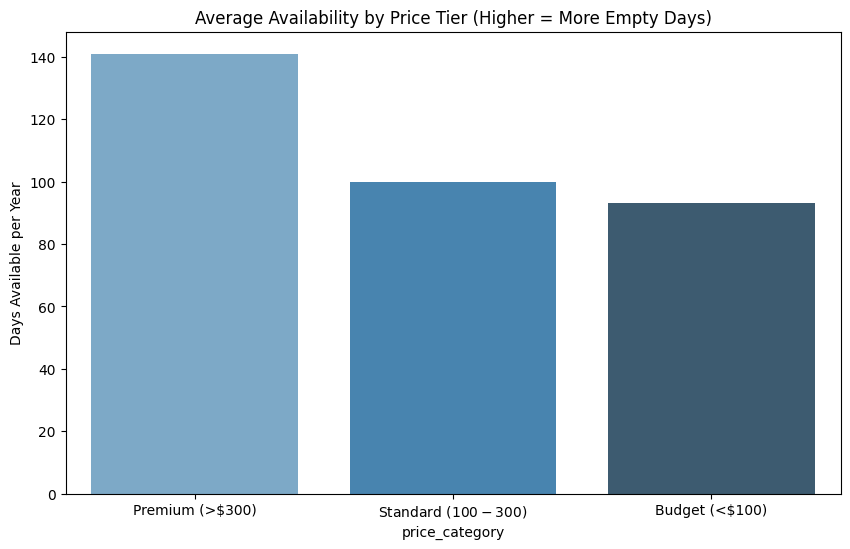

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure you run the query_segmentation first!
plt.figure(figsize=(10, 6))
sns.barplot(x='price_category', y='avg_days_available', data=result_segmentation,
            hue='price_category', palette='Blues_d', legend=False)
plt.title('Average Availability by Price Tier (Higher = More Empty Days)')
plt.ylabel('Days Available per Year')
plt.show()